CNN 사전학습 모델:
- 빅데이터를 통해 학습이 완료된 모델: 새로운 작업에 적용해 임의로 학습시킬 수 있다.

1. AlexNet:
- 장점 : 구조가 간단
- 단점 : 과적합에 취약, 특징 추출 횟수 적음
2. VGGNet:
- 장점 : 필터가 작아 세부 특징 검출 용이, 구조가 간단
- 단점 : 레이어 구조가 급격해 기울기 소실 문제에 취약, 모델 자체 크기가 크고 속도라 느림
- (ReLU가 만능은 아님)
3. GoogLeNet(inceptionNet):
- 장점 : 모델이 가볍고 학습 속도가 빨라서 이미지 데이터에 매우 효율적이다.
- 단점 : 모델 구조가 매우 어렵다
4. ResNet(Residual Network):
- 장점: Skip Connection 구조를 통한 기울기 소실 문제 최소화
- 단점: 구조가 깊어 모델이 무거운 편이라 CPU/RAM 소모가 크다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [2]:
# GPU/CPU 사용 지정
# GPU를 사용할 수 없을때, 내 그래픽카드 성능 확인해서 알맞은 그래픽 드라이버 다운로드 하기.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA(GPU)를 사용합니다.")
else:
    device = torch.device("cpu")
    print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

CUDA(GPU)를 사용합니다.


In [3]:
# myResnet 클래스 정의: 어떤 구조든 사용할 수 있음.
class myResNet(nn.Module):
    def __init__(self):
        super(myResNet, self).__init__()
        # ResNet 18 모델 로드
        self.resnet = models.resnet18(pretrained=False)
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc =nn.Linear(num_ftrs, 10) # 클래스 수가 10개라서 10으로 지정.

    def forward(self, x):
        return self.resnet(x)

In [4]:
# CIFAR10 데이터셋 로드 및 전처리
import torch.utils

transform = transforms.Compose([ #Compose는 transform안에 있는 데이터를 병렬화 하는것
    transforms.ToTensor(), # 이미지 데이터를 numpy화 할수 없어서 사용하는 것
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2434, 0.2615]) # 알려진 CIFA10의 평균과 표준편차
]) # RGB의 평균과 표준편차임.

train_dataset = datasets.CIFAR10('./CIFA10', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./CIFA10', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


In [5]:
# 모델, 손실 함수 ,최적화 알고리즘 설정
model = myResNet().to(device) # GPU에 데이터 셋이랑 돌릴 모델이 필수적으로 있어야함. 그 과정임.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

c:\ProgramData\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [7]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available(): # cuda 사용가능할때 넣는 함수, GPU에 input 데이터와 target 데이터가 들어가야함.
            data, target = data.to(device), target.to(device) 
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
       
# 예측값 계산(가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)

# 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()

# 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}, Training loss: {train_loss: .4f}')
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy) # 정확도 기록을 위한 리스트에 추가


In [8]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data. to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss: .4f}, Accuracy: {accuracy: .2f}%')

In [9]:
# 훈련 및 테스트 실행
import time
start_time = time.time()

for epoch in range(0,10):
    start_epoch = time.time()
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
    elapsed_time = time.time() - start_epoch
    print(f"Epoch time: {elapsed_time:.2f} seconds")
elapsed_time = time.time() - start_time
print(f"Total elapsed time: {elapsed_time:.2f} seconds") 

Epoch 1, Training loss:  1.5437
Test loss:  1.2880, Accuracy:  54.70%
Epoch time: 30.44 seconds
Epoch 2, Training loss:  1.1449
Test loss:  1.0674, Accuracy:  62.19%
Epoch time: 30.24 seconds
Epoch 3, Training loss:  0.9397
Test loss:  1.0100, Accuracy:  65.24%
Epoch time: 30.29 seconds
Epoch 4, Training loss:  0.7901
Test loss:  0.9234, Accuracy:  68.19%
Epoch time: 30.40 seconds
Epoch 5, Training loss:  0.6674
Test loss:  0.9142, Accuracy:  68.89%
Epoch time: 30.75 seconds
Epoch 6, Training loss:  0.5659
Test loss:  0.8959, Accuracy:  70.48%
Epoch time: 30.56 seconds
Epoch 7, Training loss:  0.4734
Test loss:  0.9140, Accuracy:  70.67%
Epoch time: 30.43 seconds
Epoch 8, Training loss:  0.3932
Test loss:  0.9410, Accuracy:  71.07%
Epoch time: 30.54 seconds
Epoch 9, Training loss:  0.3290
Test loss:  0.9895, Accuracy:  71.43%
Epoch time: 30.80 seconds
Epoch 10, Training loss:  0.2701
Test loss:  1.0934, Accuracy:  70.24%
Epoch time: 30.38 seconds
Total elapsed time: 304.84 seconds


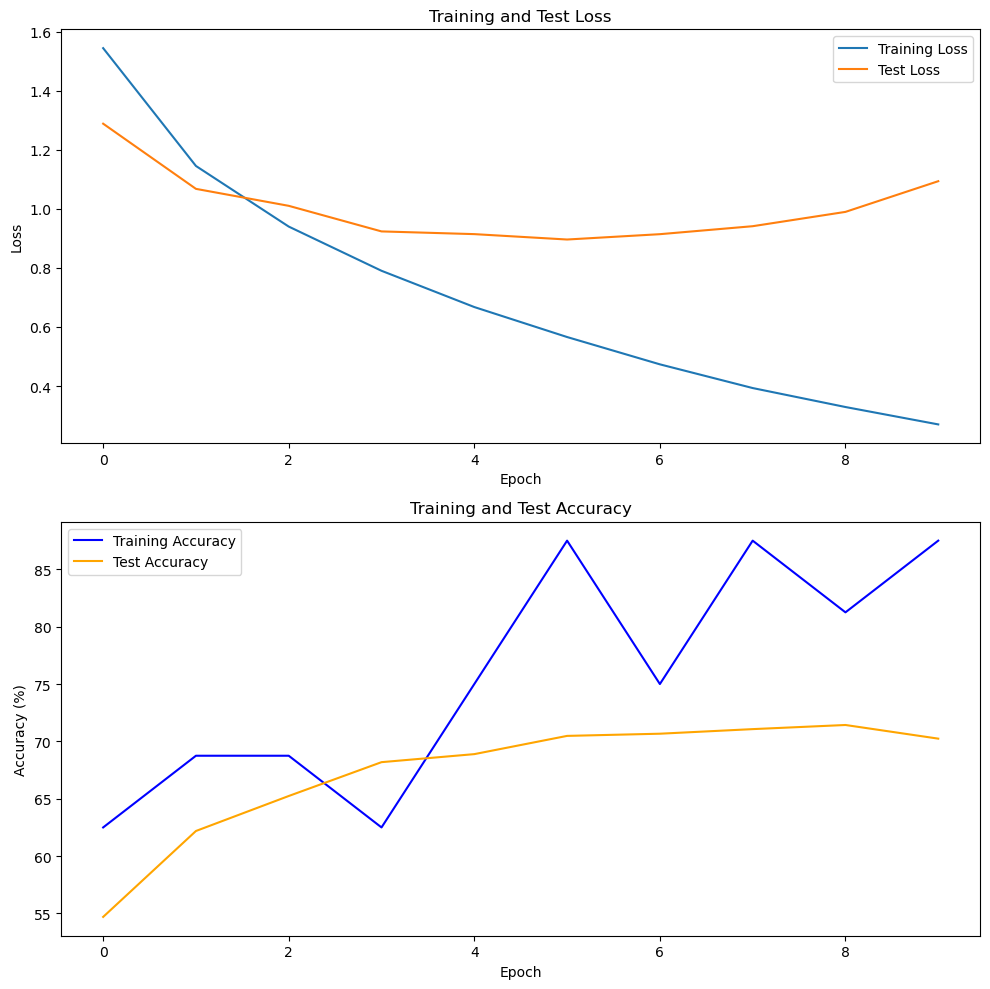

In [11]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10,10))

axs[0].plot(train_losses, label = 'Training Loss')
axs[0].plot(test_losses, label= 'Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

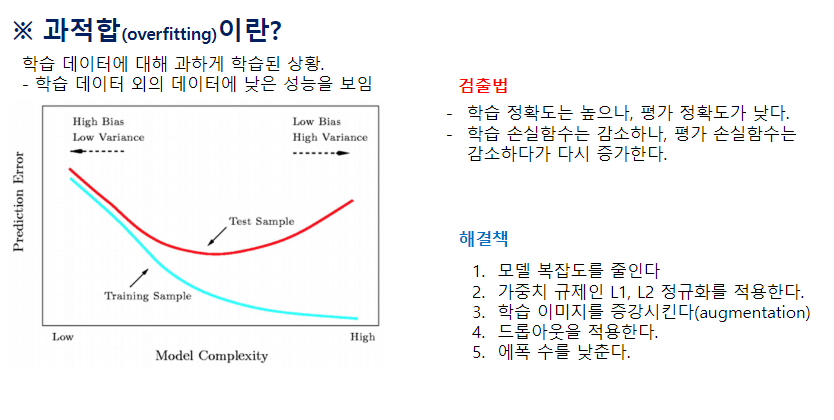

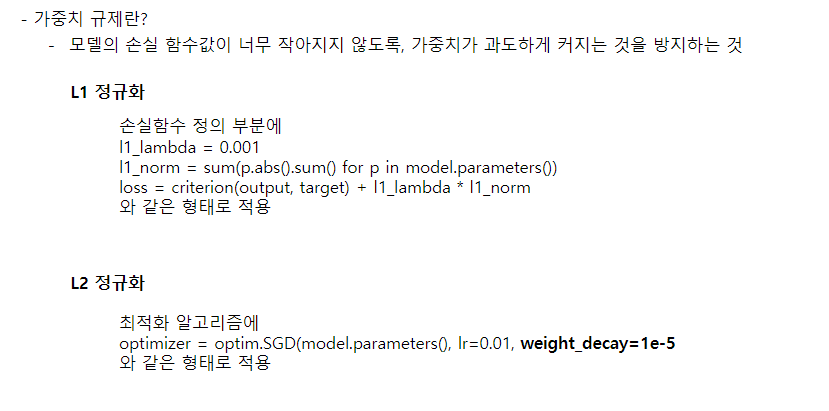

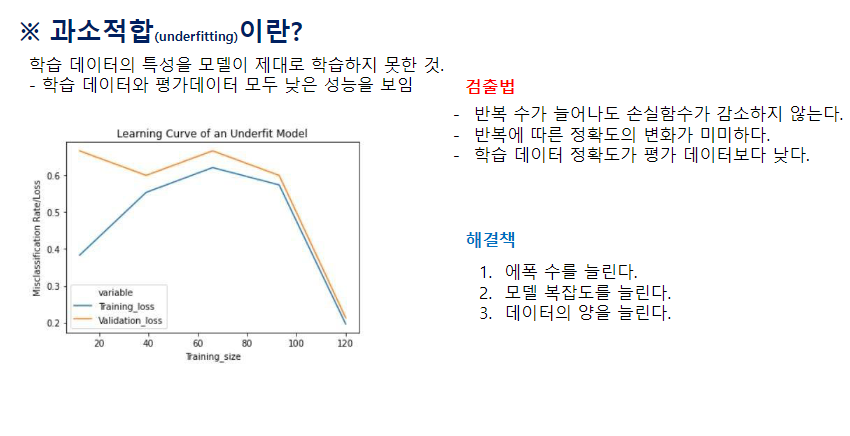

보통 과소적합은 epoch 수를 늘리면 해결됨

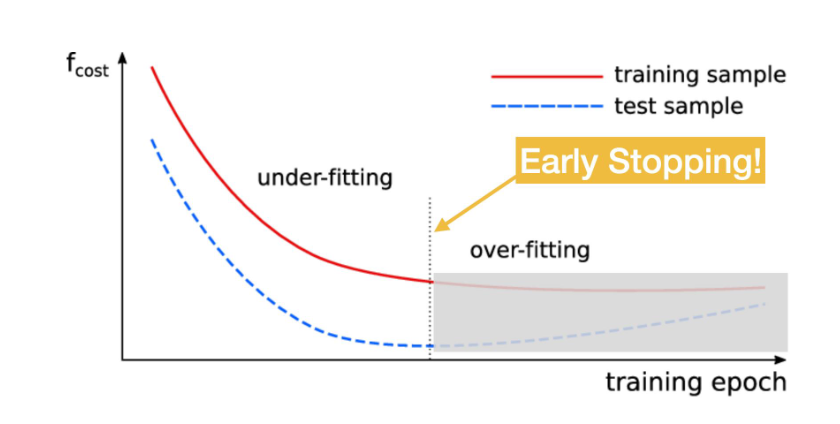

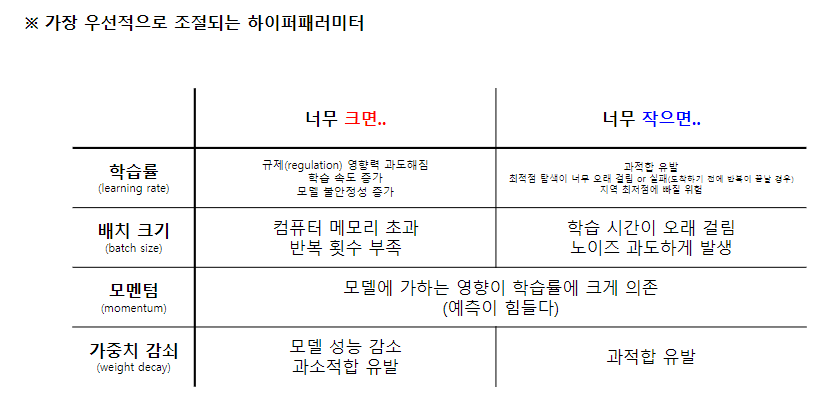

모델 조정 시 조절할 만한 하이퍼패러미터:

1. 배치 사이즈 설정
- 한 번에 학습하는 이미지의 수
- 너무 크면 메모리가 부족해지고, 너무 적으면 편향된 학습을 일으킴
2. 드롭아웃 적용
- 전체 노드 밀도를 조절하는 패러미터, 규제와 매우 유사한 효과
- 과도하면 과소적합, 너무 작으면 과적합 유발
3. 네트워크 구조 변경
- 레이어의 수, 구성 또는 깊이 조절
- 적절한 사전학습 모델 사용 

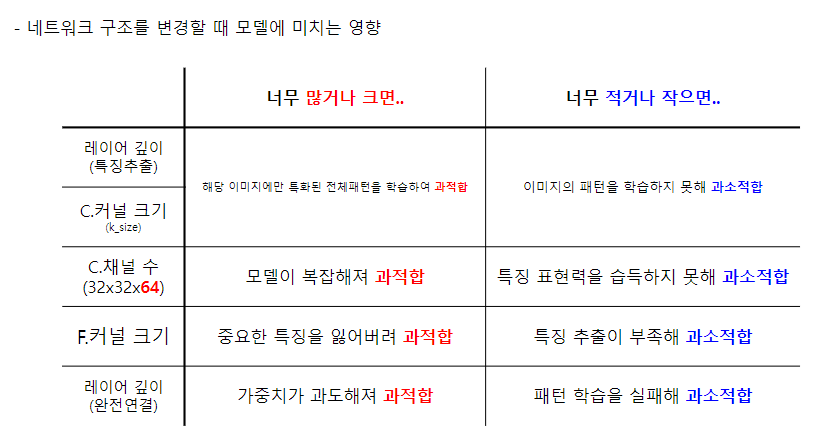

In [12]:
if torch.cuda.is_available:
    device = torch.device('cuda')
    print("CUDA(GPU)를 사용합니다.")
else:
    device = torch.device('cpu')
    print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")
# myResNet 클래스 정의
class myResNet(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(myResNet, self).__init__()
        # ResNet18 모델 로드
        self.resnet = models.resnet18(pretrained=False)
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x):
        x = self.resnet(x)
        x = self.dropout(x)
        return x

CUDA(GPU)를 사용합니다.


In [13]:
# CIFA10 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2434, 0.2615]) # 알려진 CIFA10의 평균과 표준편차
]) # RGB의 평균과 표준편차임.

train_dataset = datasets.CIFAR10('./CIFA10', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./CIFA10', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델, 손실 함수 설정(최적화 알고리즘은 RandomizedSearchCV에서 설정)
model = myResNet().to(device)
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified


c:\ProgramData\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
# 훈련 함수
def train_and_evaluate(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available(): # cuda 사용가능할때 넣는 함수, GPU에 input 데이터와 target 데이터가 들어가야함.
            data, target = data.to(device), target.to(device) 
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
       
# 예측값 계산(가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
# 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()

# 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    accuracy = 100. * correct / total
    return train_loss, accuracy

In [16]:
# log가 기준이기때문에 log를 사용
import numpy as np

lr_list = np.exp(np.random.uniform(np.log(0.0001), np.log(0.1), size=100))
momentum_list = np.arange(0.5, 1.0, 0.1)
weight_decay_list = np.exp(np.random.uniform(np.log(0.0001), np.log(0.1), size=100))
dropout_rate_list = np.arange(0.0, 0.6, 0.1)

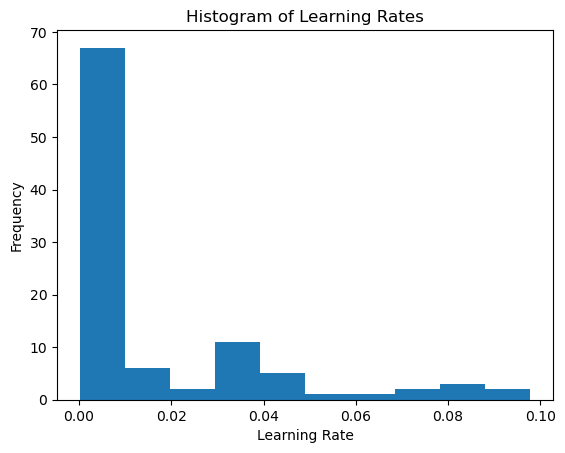

In [17]:
plt.hist(lr_list)
plt.xlabel('Learning Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Learning Rates')
plt.show()

In [26]:
# torch가 랜덤서치를 지원하지 않아서, 변환를 해야함(래핑)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, lr = 0.01, momentum = 0.5, weight_decay = 0.0, dropout_rate = 0.0):
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.model = myResNet(dropout_rate=self.dropout_rate).to(device)
        self.criterion = nn.CrossEntropyLoss()

    def fit(self, X, y):
        optimizer = optim.SGD(self.model.parameters(), lr = self.lr, momentum = self.momentum, weight_decay = self.weight_decay)
        train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X), torch.LongTensor(y))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

        for epoch in range(10): # 간단한 예시로 10 epoch 훈련
            train_and_evaluate(self.model, train_loader, optimizer, self.criterion, device)

        return self
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.Tensor(X).to(device)
            outputs = self.model(X_tensor)
            _, predcited = torch.Max(outputs.data, 1)
        return predcited.cpu().numpy()

In [27]:
train_input_list = []
train_target_list = []
test_input_list = []
test_target_list = []

for data, target in train_loader:
    train_input_list.append(data.cpu().numpy())
    train_target_list.append(target.cpu().numpy())

for data, target in test_loader:
    test_input_list.append(data.cpu().numpy())
    test_target_list.append(target.cpu().numpy())

train_input = np.concatenate(train_input_list)
train_target = np.concatenate(train_target_list).flatten()

test_input = np.concatenate(test_input_list)
test_target = np.concatenate(test_target_list).flatten()

In [29]:
param_dist = {
    'lr': lr_list,
    'momentum': momentum_list,
    'weight_decay': weight_decay_list,
    'dropout_rate': dropout_rate_list
}

# RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    estimator = PyTorchClassifier(),
    param_distributions = param_dist,
    n_iter=10, # 탐색할 매개변수 조합 수
    scoring= 'accuracy',
    cv = 5, # 교차 검증 폴드 수
    verbose = 2,
    random_state = 42,
    n_jobs=-1 # 모든 CPU 코어 사용
)

# RandomizedSearchCV 실행 
# 사양이 안되니 돌리지 말것!
# random_search.fit(train_input, train_target)

c:\ProgramData\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\ProgramData\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
